In [5]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F740566%2F1633128%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T010912Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2d32b3ac332c908d4336839d4d70a5c6bb07a9807dd2ea484700ec9c4b451fd41d35de5cdbe14ef0241b70f18947add0efb260dc737c16ec3d5c464065ed0a03c60fbd9a02252fa18ec716d95c7a394a79878385a8fdc4986e85a33836f2d3e3f033ebc2bb41dad140290540591fbbbbfd0e123f3ac7f3fb397016a35ae567f5e71a996005215579cf341ef2b773c3ff22da486f77a46a409e941410f20caa512ccfb50a0d024eb551a304580ff2d2d61a28f265f27605d648af7c0943c92cc3d90a352f0672a60fa8571ccc3ccdbde16a980a79f83be6ec3ff420e37b31e7216993c4e7393101e37175345a8cb4be6ce941613edc67539631929e4d2e9994c3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 67239488 bytes downloaded
Downloaded and uncompressed: brain-tumor-detection
Data source import complete.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  # Corrected import statement
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import RMSprop, Adam
import glob
from PIL import Image

# IGNORING UNNECESSARY WARNINGS
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)




# PATH PROCESS

#### TRAIN

In [7]:
No_Data_Path = Path("../input/brain-tumor-detection/no")
Yes_Data_Path = Path("../input/brain-tumor-detection/yes")

In [8]:
No_JPG_Path = list(No_Data_Path.glob(r"*.jpg"))
Yes_JPG_Path = list(Yes_Data_Path.glob(r"*.jpg"))

In [9]:
print(No_JPG_Path[0:5])
print("-----"*20)
print(Yes_JPG_Path[0:5])

[PosixPath('../input/brain-tumor-detection/no/no408.jpg'), PosixPath('../input/brain-tumor-detection/no/no1083.jpg'), PosixPath('../input/brain-tumor-detection/no/no309.jpg'), PosixPath('../input/brain-tumor-detection/no/no1046.jpg'), PosixPath('../input/brain-tumor-detection/no/no120.jpg')]
----------------------------------------------------------------------------------------------------
[PosixPath('../input/brain-tumor-detection/yes/y260.jpg'), PosixPath('../input/brain-tumor-detection/yes/y800.jpg'), PosixPath('../input/brain-tumor-detection/yes/y965.jpg'), PosixPath('../input/brain-tumor-detection/yes/y656.jpg'), PosixPath('../input/brain-tumor-detection/yes/y1492.jpg')]


In [10]:
Yes_No_List = []

for No_JPG in No_JPG_Path:
    Yes_No_List.append(No_JPG)

for Yes_JPG in Yes_JPG_Path:
    Yes_No_List.append(Yes_JPG)

In [11]:
print(Yes_No_List[0:10])

[PosixPath('../input/brain-tumor-detection/no/no408.jpg'), PosixPath('../input/brain-tumor-detection/no/no1083.jpg'), PosixPath('../input/brain-tumor-detection/no/no309.jpg'), PosixPath('../input/brain-tumor-detection/no/no1046.jpg'), PosixPath('../input/brain-tumor-detection/no/no120.jpg'), PosixPath('../input/brain-tumor-detection/no/no677.jpg'), PosixPath('../input/brain-tumor-detection/no/no1304.jpg'), PosixPath('../input/brain-tumor-detection/no/no22.jpg'), PosixPath('../input/brain-tumor-detection/no/no1269.jpg'), PosixPath('../input/brain-tumor-detection/no/no731.jpg')]


In [12]:
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Yes_No_List))

In [13]:
print(JPG_Labels[0:10])

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']


In [14]:
print("NO COUNTING: ", JPG_Labels.count("no"))
print("YES COUNTING: ", JPG_Labels.count("yes"))

NO COUNTING:  1500
YES COUNTING:  1500


In [15]:
JPG_Path_Series = pd.Series(Yes_No_List,name="JPG").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels,name="TUMOR_CATEGORY")

In [16]:
Main_Train_Data = pd.concat([JPG_Path_Series,JPG_Category_Series],axis=1)

In [17]:
print(Main_Train_Data.head(-1))

                                               JPG TUMOR_CATEGORY
0      ../input/brain-tumor-detection/no/no408.jpg             no
1     ../input/brain-tumor-detection/no/no1083.jpg             no
2      ../input/brain-tumor-detection/no/no309.jpg             no
3     ../input/brain-tumor-detection/no/no1046.jpg             no
4      ../input/brain-tumor-detection/no/no120.jpg             no
...                                            ...            ...
2994  ../input/brain-tumor-detection/yes/y1066.jpg            yes
2995     ../input/brain-tumor-detection/yes/y0.jpg            yes
2996  ../input/brain-tumor-detection/yes/y1425.jpg            yes
2997  ../input/brain-tumor-detection/yes/y1161.jpg            yes
2998   ../input/brain-tumor-detection/yes/y355.jpg            yes

[2999 rows x 2 columns]


#### TEST

In [18]:
Prediction_Path = Path("../input/brain-tumor-detection/pred")

In [19]:
Test_JPG_Path = list(Prediction_Path.glob(r"*.jpg"))

In [20]:
print(Test_JPG_Path[0:5])

[PosixPath('../input/brain-tumor-detection/pred/pred23.jpg'), PosixPath('../input/brain-tumor-detection/pred/pred54.jpg'), PosixPath('../input/brain-tumor-detection/pred/pred12.jpg'), PosixPath('../input/brain-tumor-detection/pred/pred45.jpg'), PosixPath('../input/brain-tumor-detection/pred/pred55.jpg')]


In [21]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [22]:
print(Test_JPG_Labels[0:5])

['pred', 'pred', 'pred', 'pred', 'pred']


In [23]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

In [24]:
Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Series],axis=1)

In [25]:
print(Test_Data.head())

                                              JPG TUMOR_CATEGORY
0  ../input/brain-tumor-detection/pred/pred23.jpg           pred
1  ../input/brain-tumor-detection/pred/pred54.jpg           pred
2  ../input/brain-tumor-detection/pred/pred12.jpg           pred
3  ../input/brain-tumor-detection/pred/pred45.jpg           pred
4  ../input/brain-tumor-detection/pred/pred55.jpg           pred


# SHUFFLING

In [26]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)

In [27]:
print(Main_Train_Data.head(-1))

                                               JPG TUMOR_CATEGORY
0      ../input/brain-tumor-detection/no/no851.jpg             no
1     ../input/brain-tumor-detection/yes/y1383.jpg            yes
2      ../input/brain-tumor-detection/no/no861.jpg             no
3      ../input/brain-tumor-detection/yes/y664.jpg            yes
4     ../input/brain-tumor-detection/yes/y1386.jpg            yes
...                                            ...            ...
2994    ../input/brain-tumor-detection/yes/y70.jpg            yes
2995  ../input/brain-tumor-detection/no/no1122.jpg             no
2996  ../input/brain-tumor-detection/yes/y1039.jpg            yes
2997   ../input/brain-tumor-detection/no/no337.jpg             no
2998   ../input/brain-tumor-detection/no/no300.jpg             no

[2999 rows x 2 columns]


# VISUALIZATION

Text(0.5, 1.0, 'no')

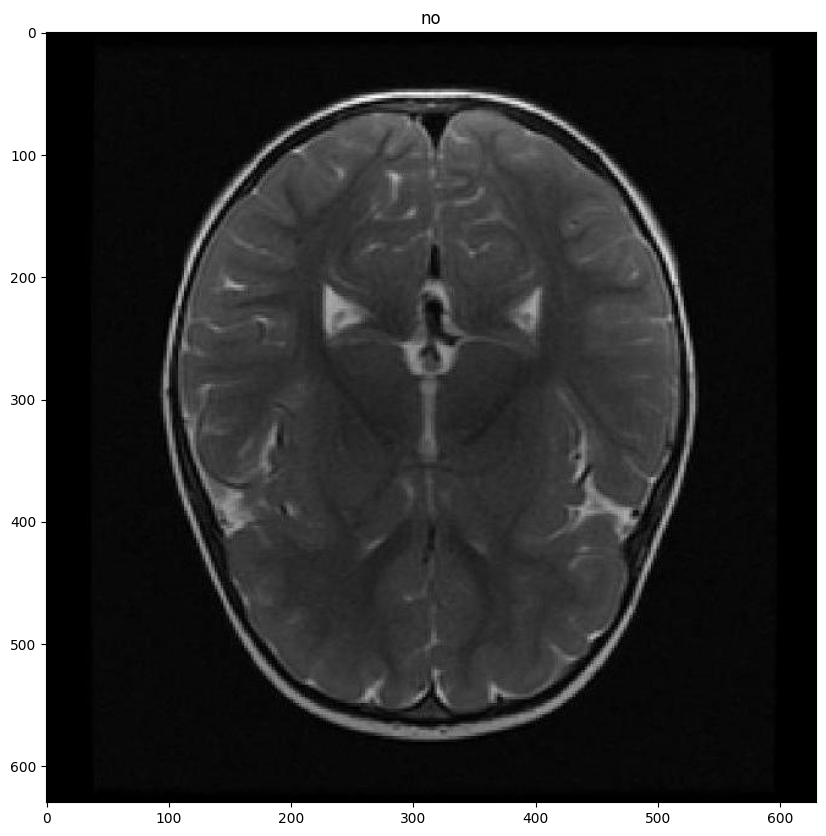

In [28]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(Main_Train_Data["JPG"][10]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])

Text(0.5, 1.0, 'no')

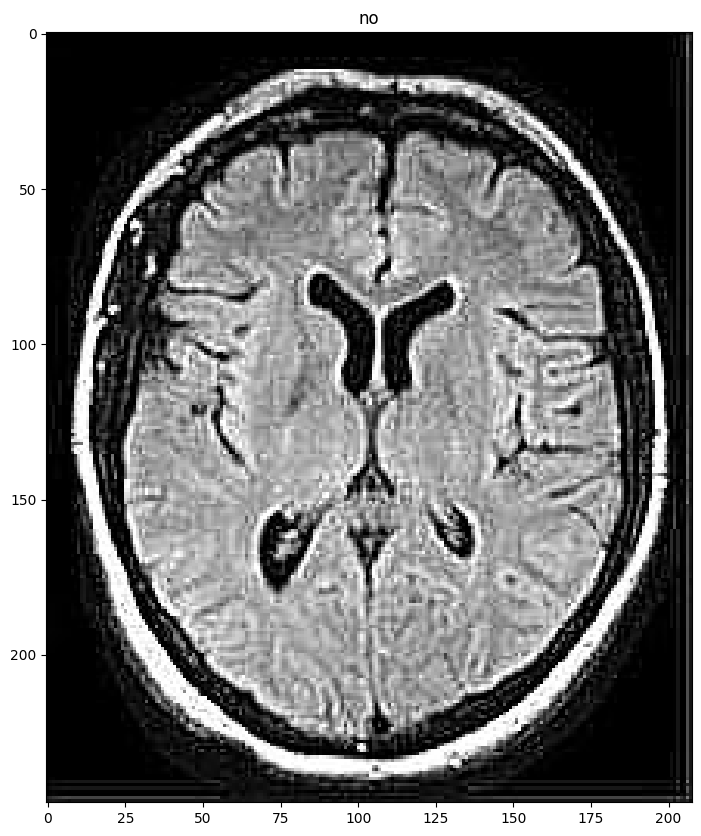

In [29]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(Main_Train_Data["JPG"][2997]))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][2997])

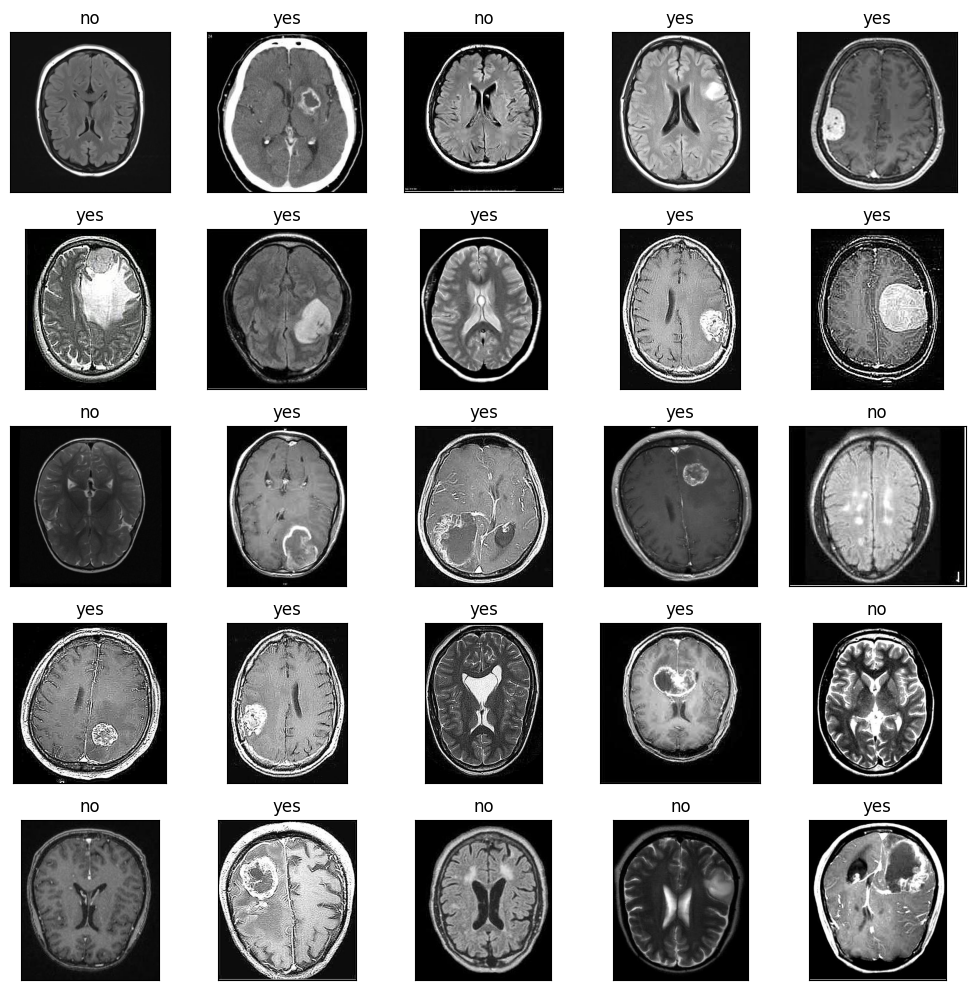

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

# MODEL TRAINING DATA

In [31]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [32]:
print(train_data.shape)

(2700, 2)


In [33]:
print(train_data.head())

                                              JPG TUMOR_CATEGORY
433   ../input/brain-tumor-detection/yes/y733.jpg            yes
1151  ../input/brain-tumor-detection/no/no746.jpg             no
73    ../input/brain-tumor-detection/yes/y736.jpg            yes
1536   ../input/brain-tumor-detection/no/no22.jpg             no
2709  ../input/brain-tumor-detection/yes/y457.jpg            yes


In [34]:
print(test_data.shape)

(300, 2)


In [35]:
print(test_data.head())

                                               JPG TUMOR_CATEGORY
1801   ../input/brain-tumor-detection/yes/y785.jpg            yes
1190   ../input/brain-tumor-detection/yes/y379.jpg            yes
1817  ../input/brain-tumor-detection/no/no1332.jpg             no
251     ../input/brain-tumor-detection/no/no41.jpg             no
2505  ../input/brain-tumor-detection/yes/y1114.jpg            yes


# IMAGE DATA GENERATOR WITHOUT DIVERSIFICATION

#### BASED ON TRAIN DATA

In [36]:
Generator_Basic = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.1)

In [37]:
Train_Set = Generator_Basic.flow_from_dataframe(dataframe=train_data,
                                               x_col="JPG",
                                               y_col="TUMOR_CATEGORY",
                                               color_mode="grayscale",
                                               class_mode="categorical",
                                               subset="training",
                                               batch_size=20,
                                               target_size=(200,200))

Found 2430 validated image filenames belonging to 2 classes.


In [38]:
Validation_Set = Generator_Basic.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200))

Found 270 validated image filenames belonging to 2 classes.


In [39]:
Test_Set = Generator_Basic.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=20,
                                              target_size=(200,200))

Found 300 validated image filenames belonging to 2 classes.


#### CHECKING

In [40]:
for data_batch,label_batch in Train_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [41]:
for data_batch,label_batch in Validation_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [42]:
for data_batch,label_batch in Test_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (20, 200, 200, 1)
LABEL SHAPE:  (20, 2)


In [43]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 1, 1, 1]
(200, 200, 1)


In [44]:
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])
print(Validation_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 0, 1, 0, 1]
(200, 200, 1)


In [45]:
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])
print(Test_Set.image_shape)

{'no': 0, 'yes': 1}
[1, 1, 0, 0, 1]
(200, 200, 1)


# CNN MODEL FOR NON-DIVERSIFICATION

#### MODEL STRUCTURE

In [46]:
Model = Sequential()

Model.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1)))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(64,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(128,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Conv2D(256,(3,3),activation="relu"))
Model.add(MaxPool2D((2,2)))
Model.add(Dropout(0.2))
#
Model.add(Flatten())
Model.add(Dropout(0.5))
Model.add(Dense(512,activation="relu"))
Model.add(Dense(2,activation="softmax"))

#### MODEL COMPILE

In [47]:
Model.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

#### MODEL FITTING

In [48]:
ANN_Model = Model.fit(Train_Set,validation_data=Validation_Set,
                      epochs=30,steps_per_epoch=120)

Epoch 1/30
120/120 [==============================] - 258s 2s/step - loss: 0.6975 - accuracy: 0.6845 - val_loss: 0.4470 - val_accuracy: 0.8111
Epoch 2/30
120/120 [==============================] - 246s 2s/step - loss: 0.4249 - accuracy: 0.8067 - val_loss: 0.3687 - val_accuracy: 0.8667
Epoch 3/30
120/120 [==============================] - 243s 2s/step - loss: 0.3417 - accuracy: 0.8515 - val_loss: 0.2306 - val_accuracy: 0.9111
Epoch 4/30
120/120 [==============================] - 244s 2s/step - loss: 0.2634 - accuracy: 0.8929 - val_loss: 0.1726 - val_accuracy: 0.9407
Epoch 5/30
120/120 [==============================] - 244s 2s/step - loss: 0.2196 - accuracy: 0.9113 - val_loss: 0.1866 - val_accuracy: 0.9407
Epoch 6/30
120/120 [==============================] - 244s 2s/step - loss: 0.1646 - accuracy: 0.9310 - val_loss: 0.1216 - val_accuracy: 0.9444
Epoch 7/30
120/120 [==============================] - 245s 2s/step - loss: 0.1516 - accuracy: 0.9494 - val_loss: 0.1090 - val_accuracy: 0.9741

#### MODEL SUMMARY

In [49]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 98, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 98, 98, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 64)        0

#### CHECKING MODEL WITH GRAPHIC

In [50]:
HistoryDict = ANN_Model.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

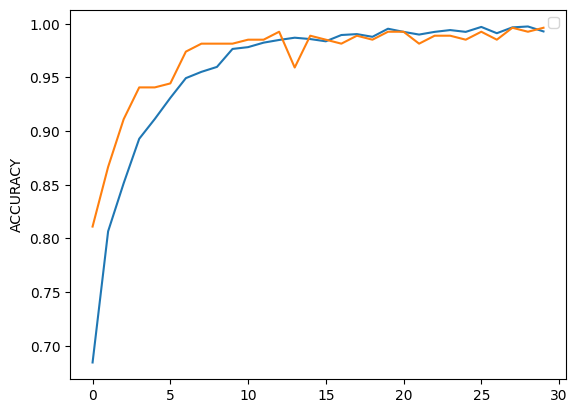

In [51]:
plt.plot(ANN_Model.history["accuracy"])
plt.plot(ANN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

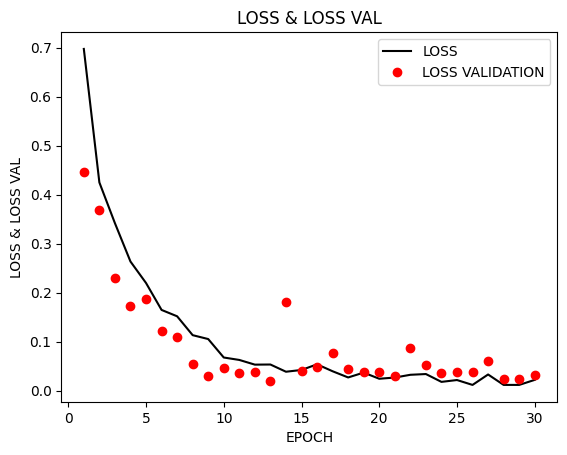

In [52]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"ro",label="LOSS VALIDATION")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

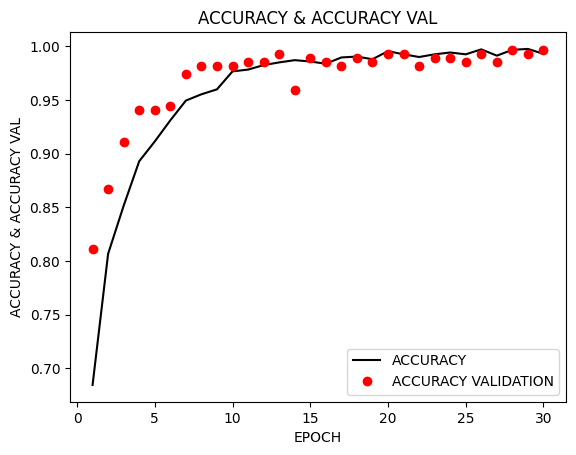

In [53]:
plt.plot(epochs,acc,"k-",label="ACCURACY")
plt.plot(epochs,val_acc,"ro",label="ACCURACY VALIDATION")
plt.title("ACCURACY & ACCURACY VAL")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY & ACCURACY VAL")
plt.legend()
plt.show()

<Axes: >

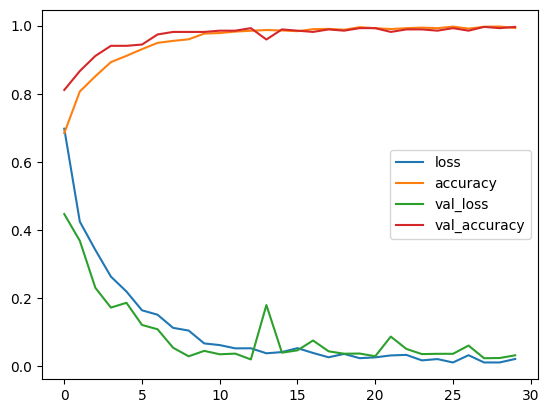

In [54]:
Dict_Summary = pd.DataFrame(ANN_Model.history)
Dict_Summary.plot()

#### PREDICTION SCORE ON DIVIDED DATA

In [55]:
Model_Results = Model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

LOSS:  0.0540
ACCURACY:  0.99


#### PREDICTION PROCESS

In [56]:
Main_Data_Prediction = pd.DataFrame({"JPG":Test_JPG_Path_Series})

In [57]:
print(Main_Data_Prediction.head())

                                              JPG
0  ../input/brain-tumor-detection/pred/pred23.jpg
1  ../input/brain-tumor-detection/pred/pred54.jpg
2  ../input/brain-tumor-detection/pred/pred12.jpg
3  ../input/brain-tumor-detection/pred/pred45.jpg
4  ../input/brain-tumor-detection/pred/pred55.jpg


In [58]:
Main_Test_Generator = ImageDataGenerator(rescale=1./255)

In [59]:
Main_Test_Set = Main_Test_Generator.flow_from_dataframe(dataframe=Main_Data_Prediction,
                                                       x_col="JPG",
                                                       y_col=None,
                                                       color_mode="grayscale",
                                                        class_mode=None,
                                                        batch_size=20,
                                                        target_size=(200,200))

Found 60 validated image filenames.


In [60]:
Model_Test_Prediction = Model.predict(Main_Test_Set)

3/3 [==============================] - 3s 695ms/step


In [61]:
Model_Test_Prediction = Model_Test_Prediction.argmax(axis=-1)

In [62]:
print(Model_Test_Prediction)

[1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1]


In [63]:
Last_Prediction = []
[Last_Prediction.append('NO') if i == 1 else Last_Prediction.append('TUMOR') for i in Model_Test_Prediction]
print(Last_Prediction)

['NO', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO']


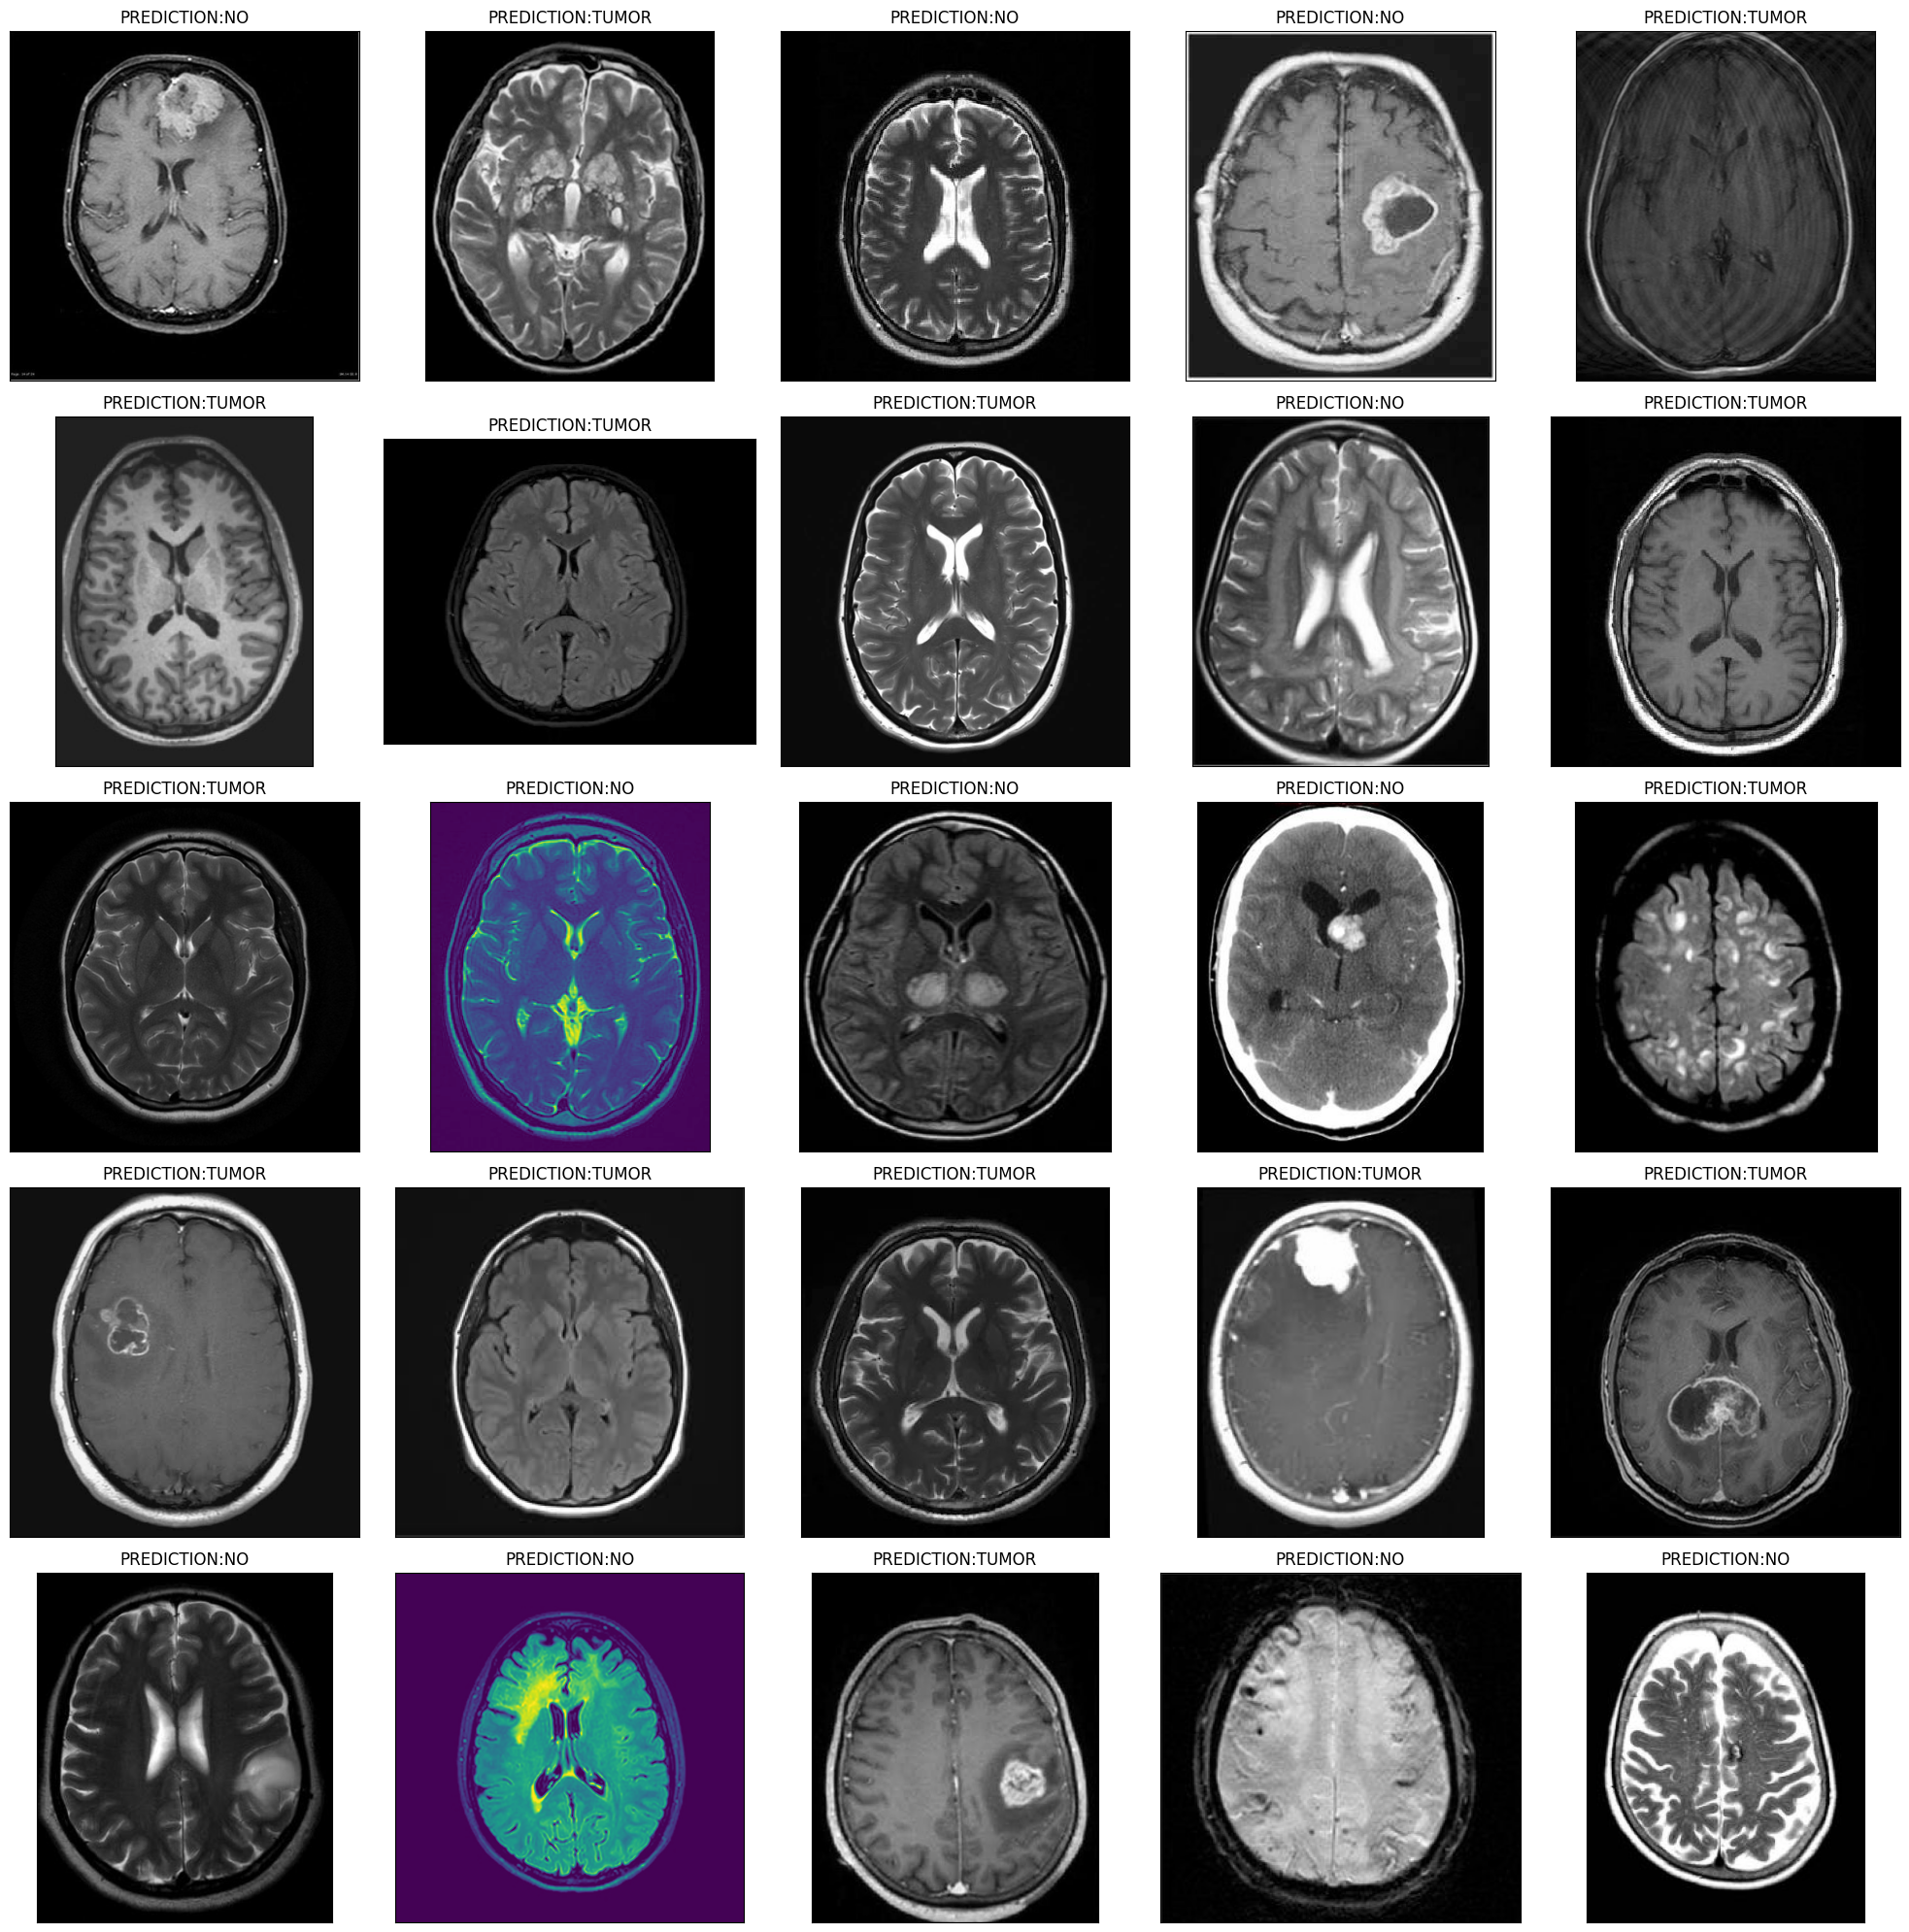

In [64]:
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Data_Prediction["JPG"].loc[i]))
    ax.set_title(f"PREDICTION:{Last_Prediction[i]}")
plt.tight_layout()
plt.show()

# IMAGE DATA GENERATOR WITH DIVERSIFICATION

In [65]:
Data_Generator_Div = ImageDataGenerator(rescale=1./255,brightness_range=[0.3,0.9],
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode="nearest",
                                       validation_split=0.1)

In [66]:
Train_Set_Div = Data_Generator_Div.flow_from_dataframe(dataframe=train_data,
                                               x_col="JPG",
                                               y_col="TUMOR_CATEGORY",
                                               color_mode="grayscale",
                                               class_mode="categorical",
                                               subset="training",
                                               batch_size=20,
                                               target_size=(200,200))

Found 2430 validated image filenames belonging to 2 classes.


In [67]:
Validation_Set_Div = Data_Generator_Div.flow_from_dataframe(dataframe=train_data,
                                                     x_col="JPG",
                                                     y_col="TUMOR_CATEGORY",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200))

Found 270 validated image filenames belonging to 2 classes.


In [68]:
Test_Set_Div = Data_Generator_Div.flow_from_dataframe(dataframe=Main_Data_Prediction,
                                                       x_col="JPG",
                                                       y_col=None,
                                                       color_mode="grayscale",
                                                        class_mode=None,
                                                        batch_size=20,
                                                        target_size=(200,200))

Found 60 validated image filenames.


# CNN MODEL WITH DIVERSIFICATION

#### MODEL STRUCTURE

In [69]:
Model_Two = Sequential()

Model_Two.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1)))
Model_Two.add(MaxPool2D((2,2)))
#
Model_Two.add(Conv2D(64,(3,3),activation="relu"))
Model_Two.add(MaxPool2D((2,2)))
#
Model_Two.add(Conv2D(128,(3,3),activation="relu"))
Model_Two.add(MaxPool2D((2,2)))
#
Model_Two.add(Conv2D(128,(3,3),activation="relu"))
Model_Two.add(MaxPool2D((2,2)))
#
Model_Two.add(Conv2D(256,(3,3),activation="relu"))
Model_Two.add(MaxPool2D((2,2)))
#
Model_Two.add(Flatten())
Model_Two.add(Dropout(0.5))
Model_Two.add(Dense(512,activation="relu"))
Model_Two.add(Dense(2,activation="softmax"))

#### MODEL COMPILE

In [70]:
Model_Two.compile(optimizer=RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

#### MODEL FITTING

In [73]:
ANN_Model_Two = Model_Two.fit(Train_Set_Div,
                              validation_data=Validation_Set_Div,
                              batch_size=20,
                      epochs=15)

Epoch 1/15
122/122 [==============================] - 213s 2s/step - loss: 0.6305 - accuracy: 0.6588 - val_loss: 0.6288 - val_accuracy: 0.6815
Epoch 2/15
122/122 [==============================] - 213s 2s/step - loss: 0.6192 - accuracy: 0.6654 - val_loss: 0.4947 - val_accuracy: 0.8037
Epoch 3/15
122/122 [==============================] - 214s 2s/step - loss: 0.5856 - accuracy: 0.7095 - val_loss: 0.5157 - val_accuracy: 0.7667
Epoch 4/15
122/122 [==============================] - 211s 2s/step - loss: 0.5535 - accuracy: 0.7333 - val_loss: 0.4583 - val_accuracy: 0.7963
Epoch 5/15
122/122 [==============================] - 214s 2s/step - loss: 0.5360 - accuracy: 0.7556 - val_loss: 0.4869 - val_accuracy: 0.7778
Epoch 6/15
122/122 [==============================] - 210s 2s/step - loss: 0.5232 - accuracy: 0.7461 - val_loss: 0.4402 - val_accuracy: 0.8185
Epoch 7/15
122/122 [==============================] - 209s 2s/step - loss: 0.5043 - accuracy: 0.7638 - val_loss: 0.4334 - val_accuracy: 0.7926

#### MODEL SUMMARY

In [74]:
print(Model_Two.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 98, 98, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 128)      

#### CHECKING MODEL WITH GRAPHIC

In [75]:
HistoryDict_Two = ANN_Model_Two.history

val_losses_Two = HistoryDict_Two["val_loss"]
val_acc_Two = HistoryDict_Two["val_accuracy"]
acc_Two = HistoryDict_Two["accuracy"]
losses_Two = HistoryDict_Two["loss"]
epochs_Two = range(1,len(val_losses_Two)+1)

In [76]:
plt.plot(ANN_Model_Two.history["accuracy"])
plt.plot(ANN_Model_Two.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

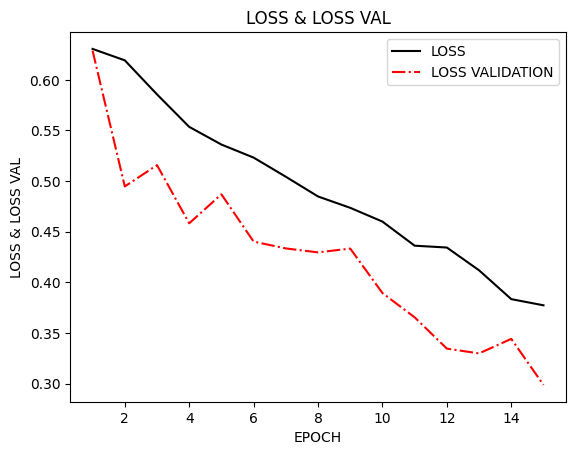

In [77]:
plt.plot(epochs_Two,losses_Two,"k-",label="LOSS")
plt.plot(epochs_Two,val_losses_Two,"r-.",label="LOSS VALIDATION")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

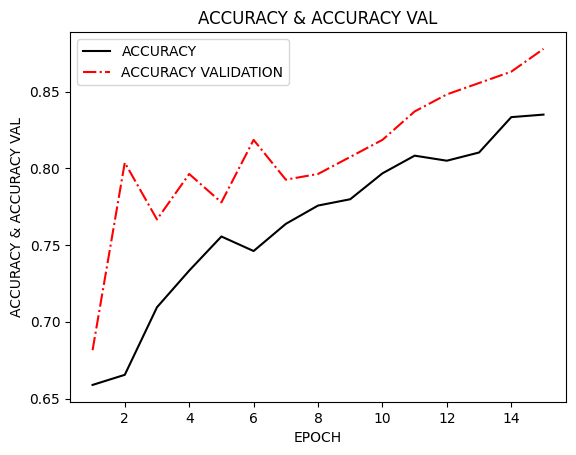

In [78]:
plt.plot(epochs_Two,acc_Two,"k-",label="ACCURACY")
plt.plot(epochs_Two,val_acc_Two,"r-.",label="ACCURACY VALIDATION")
plt.title("ACCURACY & ACCURACY VAL")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY & ACCURACY VAL")
plt.legend()
plt.show()

<Axes: >

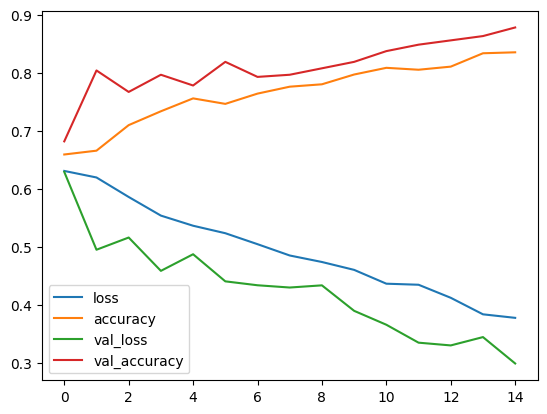

In [79]:
Dict_Summary_Two = pd.DataFrame(ANN_Model_Two.history)
Dict_Summary_Two.plot()

#### PREDICTION SCORE ON DIVIDED DATA

In [80]:
Model_Results_Two = Model_Two.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results_Two[0])
print("ACCURACY:  " + "%.2f" % Model_Results_Two[1])

LOSS:  0.3045
ACCURACY:  0.88


#### PREDICTION PROCESS

In [81]:
Model_Test_Prediction_Two = Model_Two.predict(Test_Set_Div)

3/3 [==============================] - 3s 575ms/step


In [82]:
Model_Test_Prediction_Two = Model_Test_Prediction_Two.argmax(axis=-1)

In [83]:
print(Model_Test_Prediction_Two)

[0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1]


In [84]:
Last_Prediction_Two = []
[Last_Prediction_Two.append('NO') if i == 1 else Last_Prediction_Two.append('TUMOR') for i in Model_Test_Prediction_Two]
print(Last_Prediction_Two)

['TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO', 'TUMOR', 'NO', 'NO', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'NO', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'TUMOR', 'NO', 'NO', 'TUMOR', 'TUMOR', 'TUMOR', 'NO', 'NO']


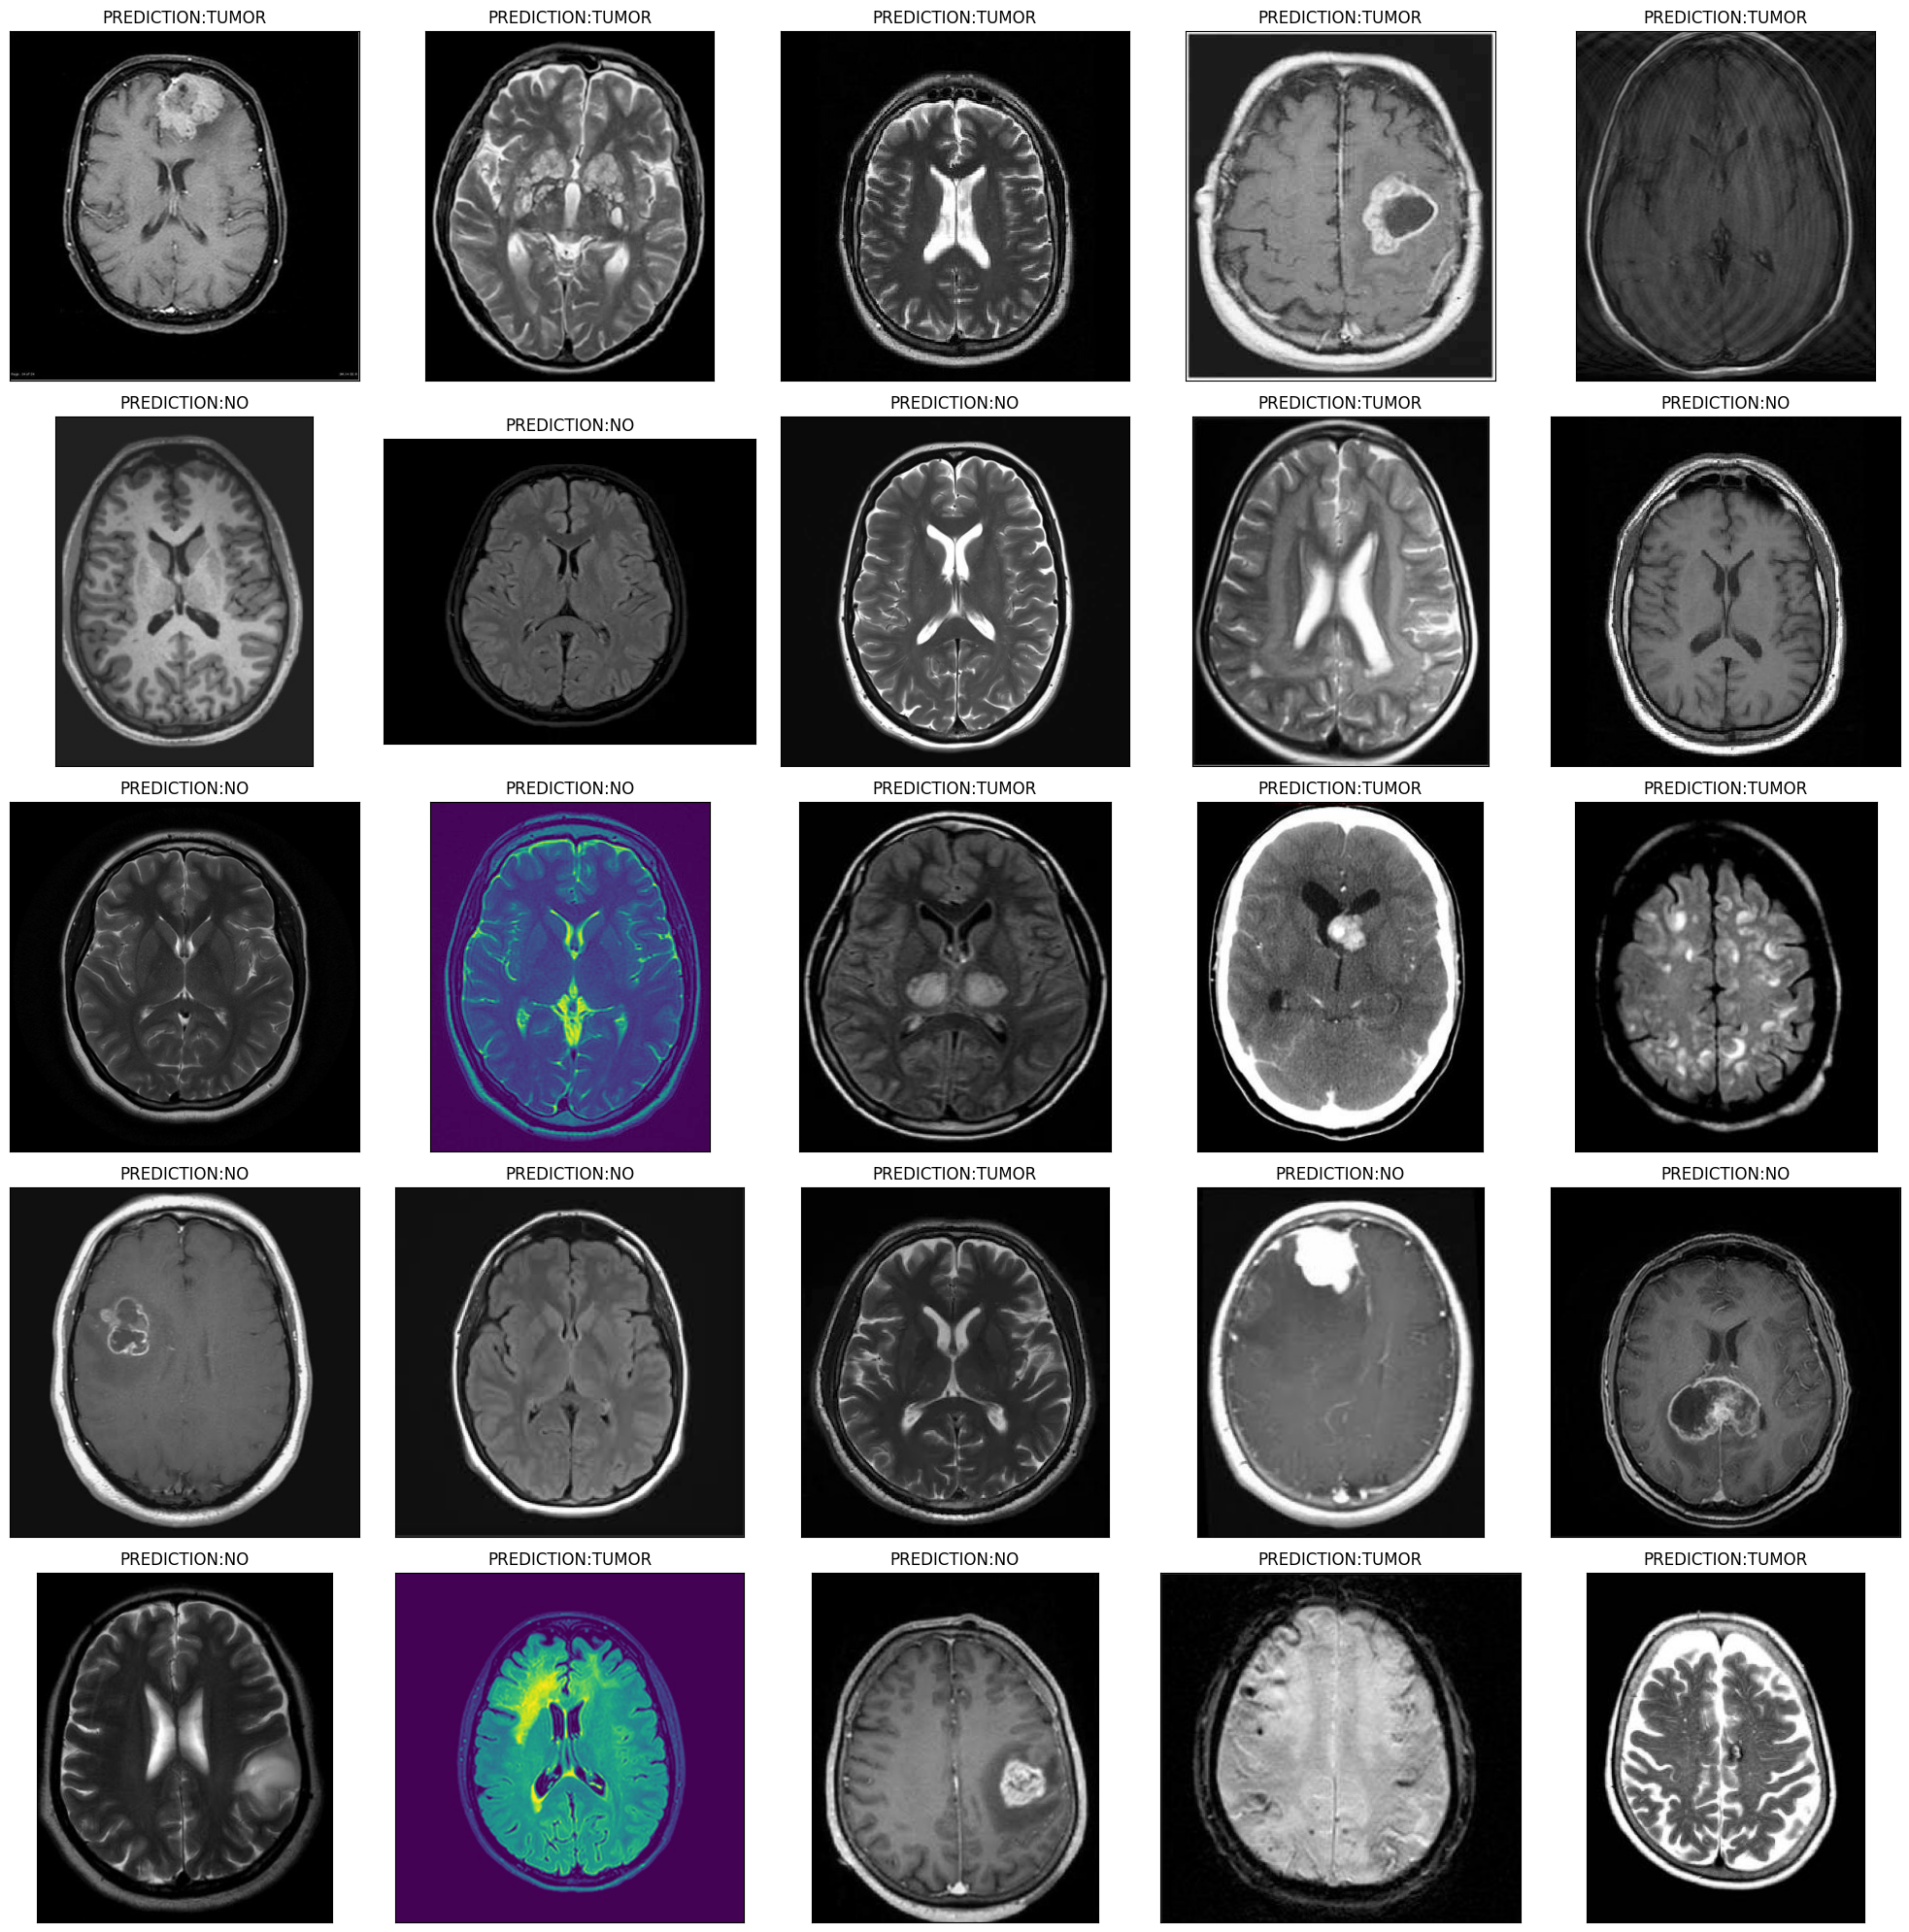

In [85]:
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Data_Prediction["JPG"].loc[i]))
    ax.set_title(f"PREDICTION:{Last_Prediction_Two[i]}")
plt.tight_layout()
plt.show()